# 💬 Sentiment Analysis — From TF-IDF to DistilBERT

**Goal:** Classify Amazon product reviews as **positive / negative**, progressing
through three stages of NLP sophistication.

| Stage | Method | Key Idea |
|-------|--------|----------|
| 1 | TF-IDF → LogReg / NB / SVM | Bag-of-words statistics |
| 2 | GloVe Embeddings → RF / XGBoost | Pre-trained semantic vectors |
| 3 | DistilBERT Fine-Tuning | Context-aware transformer |

**Dataset:** Amazon Polarity — 20 k train / 4 k test (balanced binary sample)

> *"Natural language processing is the art of turning human language into numbers
> that machines can reason about."*

---
## 0. Configuration & Imports

**Technical:** Every constant, path, and hyperparameter is defined at the top for
full reproducibility. All random seeds are pinned to `SEED = 42`.

**NLP context:** Reproducibility is critical in NLP research — small changes in
preprocessing, tokenisation, or random initialisation can swing accuracy by 1-2 %.
Pinning every seed eliminates this noise and lets you isolate the effect of each
architectural decision (TF-IDF → GloVe → Transformer).

In [1]:
# ── Setup ────────────────────────────────────────────────────────────
import warnings, os, re, string, random, time, gc
from pathlib import Path

warnings.filterwarnings("ignore")
os.environ["KMP_DUPLICATE_LIB_OK"]  = "TRUE"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import joblib
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score,
    accuracy_score, precision_score, recall_score,
)
from wordcloud import WordCloud
from xgboost import XGBClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)

In [2]:
# ── Reproducibility ──────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
transformers.set_seed(SEED)

# ── Device ───────────────────────────────────────────────────────────
try:
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    _ = torch.randn(2, 2).to(DEVICE)
except Exception:
    DEVICE = torch.device("cpu")

# ── Data parameters ──────────────────────────────────────────────────
TRAIN_SIZE   = 20_000
TEST_SIZE    =  4_000
MAX_FEATURES = 50_000
MAX_SEQ_LEN  = 128

# ── Paths ────────────────────────────────────────────────────────────
DATA_DIR       = Path("data")
EMBEDDINGS_DIR = Path("embeddings")
OUTPUT_DIR     = Path("outputs")
FIGURES_DIR    = OUTPUT_DIR / "figures"
MODELS_DIR     = OUTPUT_DIR / "models"
RESULTS_DIR    = OUTPUT_DIR / "results"
for d in [DATA_DIR, EMBEDDINGS_DIR, FIGURES_DIR, MODELS_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ── DistilBERT hyperparams ──────────────────────────────────────────
BERT_MODEL_NAME = "distilbert-base-uncased"
BERT_EPOCHS     = 3
BERT_BATCH_SIZE = 32
BERT_LR         = 2e-5
BERT_WARMUP     = 0.1

# ── GloVe ────────────────────────────────────────────────────────────
GLOVE_URL = "http://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_DIM = 100

# ── Styling ──────────────────────────────────────────────────────────
POS_COLOR = "#2ecc71"
NEG_COLOR = "#e74c3c"
CLASS_PALETTE = {0: NEG_COLOR, 1: POS_COLOR}
LABEL_MAP = {0: "Negative", 1: "Positive"}
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams.update({"figure.figsize": (10, 6), "axes.titlesize": 14})

print(f"🖥  Device:       {DEVICE}")
print(f"🤗 Transformers: {transformers.__version__}")
print(f"🔥 PyTorch:      {torch.__version__}")
print(f"📊 MPS available: {torch.backends.mps.is_available()}")
print("Setup complete ✅")

🖥  Device:       mps
🤗 Transformers: 5.2.0
🔥 PyTorch:      2.10.0
📊 MPS available: True
Setup complete ✅


---
## 1. Data Loading & First Inspection

**Technical:** Load a stratified 50/50 sample of the Amazon Polarity dataset
(20 k train, 4 k test). The text is formed by concatenating `title + ". " + content`.

**NLP context:** Amazon Polarity is a standard benchmark in sentiment analysis
research, first introduced alongside character-level CNNs (Zhang et al., 2015).
Binary sentiment (positive/negative) is the ideal starting problem before tackling
multi-class star ratings — it isolates the core NLP challenge (understanding
language polarity) without the confounding difficulty of distinguishing between,
say, 3-star and 4-star reviews.

In [3]:
# ── Load data (from cached CSV or download) ──────────────────────────
train_csv = DATA_DIR / "amazon_train.csv"
test_csv  = DATA_DIR / "amazon_test.csv"

if train_csv.exists() and test_csv.exists():
    df_train = pd.read_csv(train_csv)
    df_test  = pd.read_csv(test_csv)
    print(f"📂 Loaded from cache — train: {len(df_train):,}  test: {len(df_test):,}")
else:
    from datasets import load_dataset
    print("⏬ Downloading Amazon Polarity (first run ≈ 2 min) …")
    ds = load_dataset("amazon_polarity")
    print(f"   Full dataset — train: {len(ds['train']):,}  test: {len(ds['test']):,}")

    def stratified_sample(dataset, n_total, seed):
        n_per = n_total // 2
        df = dataset.to_pandas()
        pos = df[df["label"] == 1].sample(n=n_per, random_state=seed)
        neg = df[df["label"] == 0].sample(n=n_per, random_state=seed)
        return (pd.concat([pos, neg])
                .sample(frac=1, random_state=seed)
                .reset_index(drop=True))

    df_train = stratified_sample(ds["train"], TRAIN_SIZE, SEED)
    df_test  = stratified_sample(ds["test"],  TEST_SIZE,  SEED)
    del ds; gc.collect()

    df_train["text"] = df_train["title"].fillna("") + ". " + df_train["content"].fillna("")
    df_test["text"]  = df_test["title"].fillna("")  + ". " + df_test["content"].fillna("")

    df_train.to_csv(train_csv, index=False)
    df_test.to_csv(test_csv, index=False)
    print(f"💾 Saved: {train_csv} ({train_csv.stat().st_size:,} bytes)")

# Ensure text column
if "text" not in df_train.columns:
    df_train["text"] = df_train["title"].fillna("") + ". " + df_train["content"].fillna("")
    df_test["text"]  = df_test["title"].fillna("")  + ". " + df_test["content"].fillna("")

y_train = df_train["label"].values
y_test  = df_test["label"].values

print(f"\n✅ Train: {df_train.shape}  Labels: {dict(pd.Series(y_train).value_counts().sort_index())}")
print(f"✅ Test:  {df_test.shape}   Labels: {dict(pd.Series(y_test).value_counts().sort_index())}")

📂 Loaded from cache — train: 20,000  test: 4,000

✅ Train: (20000, 4)  Labels: {0: 10000, 1: 10000}
✅ Test:  (4000, 4)   Labels: {0: 2000, 1: 2000}


In [4]:
# ── Quick look ────────────────────────────────────────────────────────
display_df = df_train[["label", "title", "text"]].head(5).copy()
display_df["text"] = display_df["text"].str[:100] + " …"
display_df["label"] = display_df["label"].map(LABEL_MAP)
display_df

,label,title,text
0,Negative,Please stop,Please stop. Most authors need credentials of ...
1,Positive,Lucybear Review,Lucybear Review. I wish they hadn't made such ...
2,Positive,Slight Improvement Over S-Video Cable,Slight Improvement Over S-Video Cable. If your...
3,Positive,Great for any age!!,Great for any age!!. I recently purchased this...
4,Negative,Sent Wrong CD,"Sent Wrong CD. I was sent the wrong CD, but th..."


In [5]:
# ── Text length statistics ────────────────────────────────────────────
df_train["word_count"] = df_train["text"].str.split().str.len()
df_test["word_count"]  = df_test["text"].str.split().str.len()

wc_stats = df_train.groupby("label")["word_count"].describe(
    percentiles=[0.5, 0.95]
).round(1)
wc_stats.index = wc_stats.index.map(LABEL_MAP)
print("Word-count statistics per class:\n")
print(wc_stats.to_string())

# DistilBERT truncation estimate (≈1.3 WordPiece tokens per word)
approx_word_limit = int(MAX_SEQ_LEN / 1.3)
pct_trunc = (df_train["word_count"] > approx_word_limit).mean()
print(f"\n⚠️  Reviews > ~{approx_word_limit} words will be truncated by "
      f"DistilBERT — {pct_trunc:.1%} of training data affected")

Word-count statistics per class:

            count  mean   std   min   50%    95%    max
label                                                  
Negative  10000.0  81.0  42.7  11.0  73.0  162.0  210.0
Positive  10000.0  75.3  42.7  12.0  66.0  158.0  202.0

⚠️  Reviews > ~98 words will be truncated by DistilBERT — 29.9% of training data affected


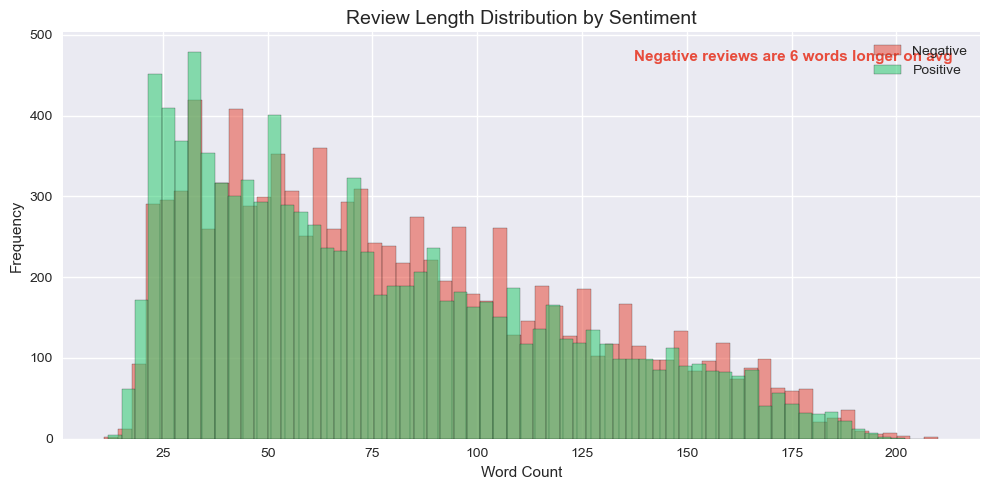

In [6]:
# ── Review length histogram by class ──────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
for label in [0, 1]:
    data = df_train[df_train["label"] == label]["word_count"]
    ax.hist(data, bins=60, alpha=0.55, color=CLASS_PALETTE[label],
            label=LABEL_MAP[label], edgecolor="k", lw=0.3)

mean_neg = df_train[df_train["label"] == 0]["word_count"].mean()
mean_pos = df_train[df_train["label"] == 1]["word_count"].mean()
diff = abs(mean_neg - mean_pos)
longer = "Negative" if mean_neg > mean_pos else "Positive"

ax.set_title("Review Length Distribution by Sentiment")
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.legend()
ax.annotate(f"{longer} reviews are {diff:.0f} words longer on avg",
            xy=(0.97, 0.93), xycoords="axes fraction", ha="right",
            fontsize=11, fontweight="bold",
            color=NEG_COLOR if longer == "Negative" else POS_COLOR)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "length_distribution.png", dpi=150)
plt.show()

In [7]:
# ── Sample reviews ────────────────────────────────────────────────────
for label, name, color in [(1, "POSITIVE", POS_COLOR), (0, "NEGATIVE", NEG_COLOR)]:
    print(f"\n{'='*60}")
    print(f"  Sample {name} Reviews")
    print(f"{'='*60}")
    samples = df_train[df_train["label"] == label].sample(3, random_state=SEED)
    for _, row in samples.iterrows():
        text = row["text"][:200] + " …" if len(row["text"]) > 200 else row["text"]
        print(f"\n  ▸ {text}")


  Sample POSITIVE Reviews

  ▸ Easy to read and understand.. I liked this book, the author Ernest J. Gaines was easy to understand and had wonderful flow with words. You got lost after just the first few pages. A lesson Before Dyin …

  ▸ Great Christmas book for children or adults. "Build Your Own Bethlehem" is a great little book for children or adults. It is beautifully illustrated & the figures are easy to assemble. The text ties t …

  ▸ The Fortunes Singles. This is a wonderful compilation of the greatest hits from a group that receives far too little airplay. Their body of work is impressive ranging from pop British Invasion hits to …

  Sample NEGATIVE Reviews

  ▸ Broke after 9 months. AVOID Farouk/CHI at all costs. My dryer stopped working after only 9 months of light use, and they won't accept the 1-year warranty because it was purchased online and not throug …

  ▸ Ugh. I have never read this author before and thought I would give him a try. This had to be the most pedestr

### 📌 Dataset Notes

- **Balanced classes:** Exactly 50/50 split → no need for class-weight adjustments
  or oversampling. This lets us focus purely on the NLP modelling decisions.
- **Text = title + content:** Titles are short (3-10 words) and often carry strong
  sentiment signal ("Great product!" vs "Waste of money"). Concatenating them gives
  the model both the headline signal and the detailed evidence.
- **Why binary?** Starting with binary classification isolates the core challenge
  (understanding language polarity) before adding the complexity of ordinal
  regression (1-5 stars). It's also the standard task in most NLP benchmarks
  (SST-2, IMDb, Amazon Polarity).

---
## 2. Text Preprocessing & EDA

**Technical:** Build a cleaning pipeline, then generate 8 diagnostic visualisations
that reveal the linguistic structure of the dataset.

**NLP context:** In real-world NLP pipelines, 80 % of the work is data
understanding and preprocessing. A model trained on dirty text (HTML tags, URLs,
encoding artefacts) will waste capacity learning irrelevant patterns. These EDA
plots guide feature engineering decisions and reveal potential data quality issues.

In [8]:
# ── Text Cleaning Pipeline ────────────────────────────────────────────
def clean_text(text: str) -> str:
    """Clean raw review text for NLP processing.

    Steps: lowercase → remove HTML → remove URLs → keep only letters
    and spaces → collapse whitespace.
    """
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Cleaning text …")
df_train["clean_text"] = df_train["text"].apply(clean_text)
df_test["clean_text"]  = df_test["text"].apply(clean_text)
print(f"✅ Cleaned {len(df_train) + len(df_test):,} reviews")

Cleaning text …
✅ Cleaned 24,000 reviews


In [9]:
# ── Before vs After Cleaning ──────────────────────────────────────────
pd.set_option("display.max_colwidth", 100)
compare = df_train[["text", "clean_text"]].sample(3, random_state=SEED).copy()
compare.columns = ["Original", "Cleaned"]
compare

,Original,Cleaned
10650,Its better than the picture. Its very small and much cooler-looking than in the picture. For som...,its better than the picture its very small and much coolerlooking than in the picture for some r...
2041,"Not an especially thorough examination of GIS and L.A.. Not well organized, repetitive in parts ...",not an especially thorough examination of gis and la not well organized repetitive in parts and ...
8668,A book that saved my first Thanksgiving. This book was easy to read and to follow. I am not the ...,a book that saved my first thanksgiving this book was easy to read and to follow i am not the be...


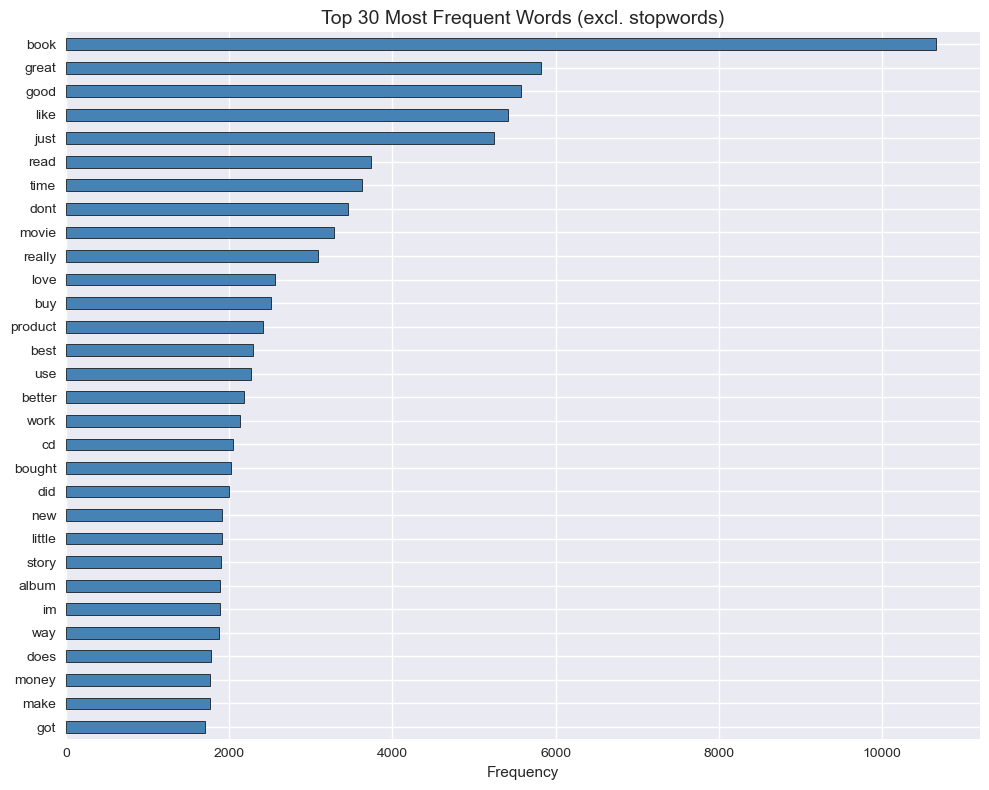

In [10]:
# ── Plot 1: Top 30 Most Frequent Words ────────────────────────────────
vec_freq = CountVectorizer(stop_words="english", max_features=10000)
X_freq = vec_freq.fit_transform(df_train["clean_text"])
word_freq = pd.Series(
    np.array(X_freq.sum(axis=0)).flatten(),
    index=vec_freq.get_feature_names_out()
).nlargest(30).sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
word_freq.plot.barh(ax=ax, color="steelblue", edgecolor="k", lw=0.5)
ax.set_title("Top 30 Most Frequent Words (excl. stopwords)")
ax.set_xlabel("Frequency")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "word_frequency.png", dpi=150)
plt.show()

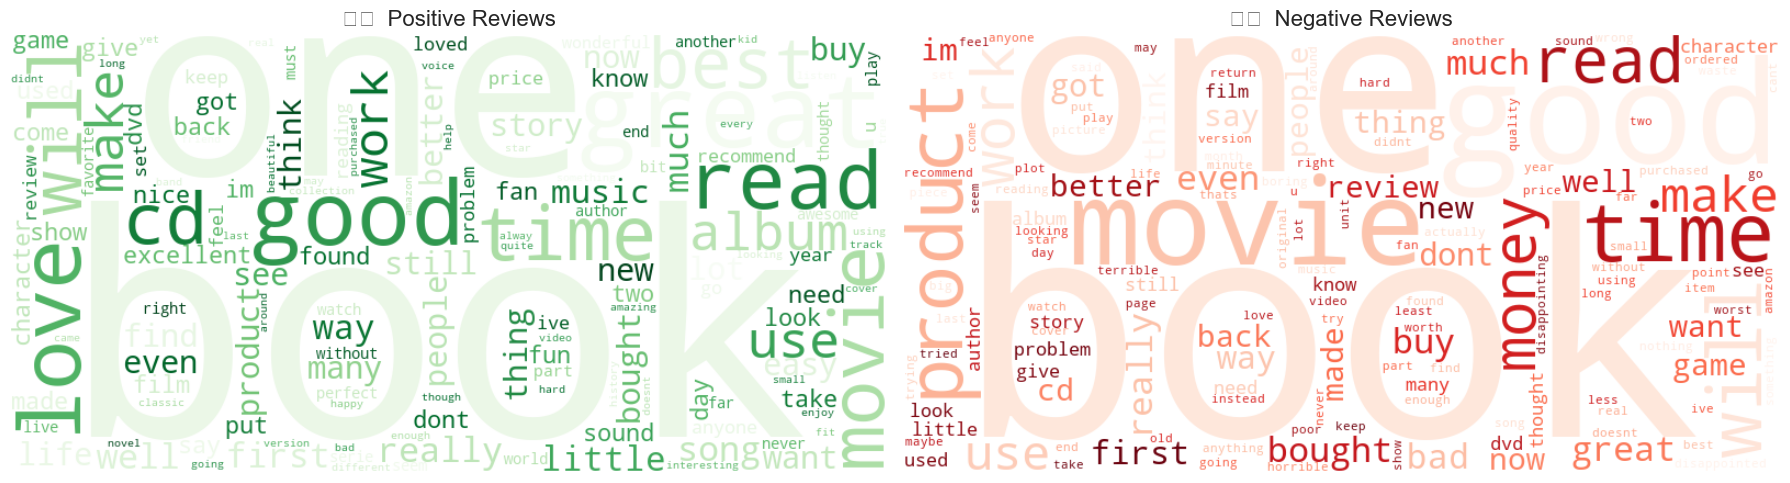

In [11]:
# ── Plots 2-3: Word Clouds (Positive & Negative) ────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, label, cmap, name in [
    (axes[0], 1, "Greens", "Positive"),
    (axes[1], 0, "Reds",   "Negative"),
]:
    text = " ".join(df_train[df_train["label"] == label]["clean_text"])
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap=cmap, random_state=SEED, max_words=150)
    wc.generate(text)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"☁️  {name} Reviews", fontsize=16)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "wordclouds.png", dpi=150)
# Also save individually
for label, fname in [(1, "wordcloud_positive"), (0, "wordcloud_negative")]:
    text = " ".join(df_train[df_train["label"] == label]["clean_text"])
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap="Greens" if label == 1 else "Reds",
                   random_state=SEED, max_words=150).generate(text)
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.imshow(wc, interpolation="bilinear"); ax2.axis("off")
    fig2.savefig(FIGURES_DIR / f"{fname}.png", dpi=150)
    plt.close(fig2)
plt.show()

💡 **Linguistic insight:** The positive cloud is dominated by *evaluative
adjectives* ("great", "good", "love", "best") — language that directly expresses
sentiment. The negative cloud includes *action verbs* ("return", "waste", "broke")
— negative reviewers describe **what went wrong**, not just how they feel. This
distinction is important: a TF-IDF model will pick up the evaluative words easily,
but understanding event descriptions ("it broke after 2 days") requires more
context — an advantage for transformers.

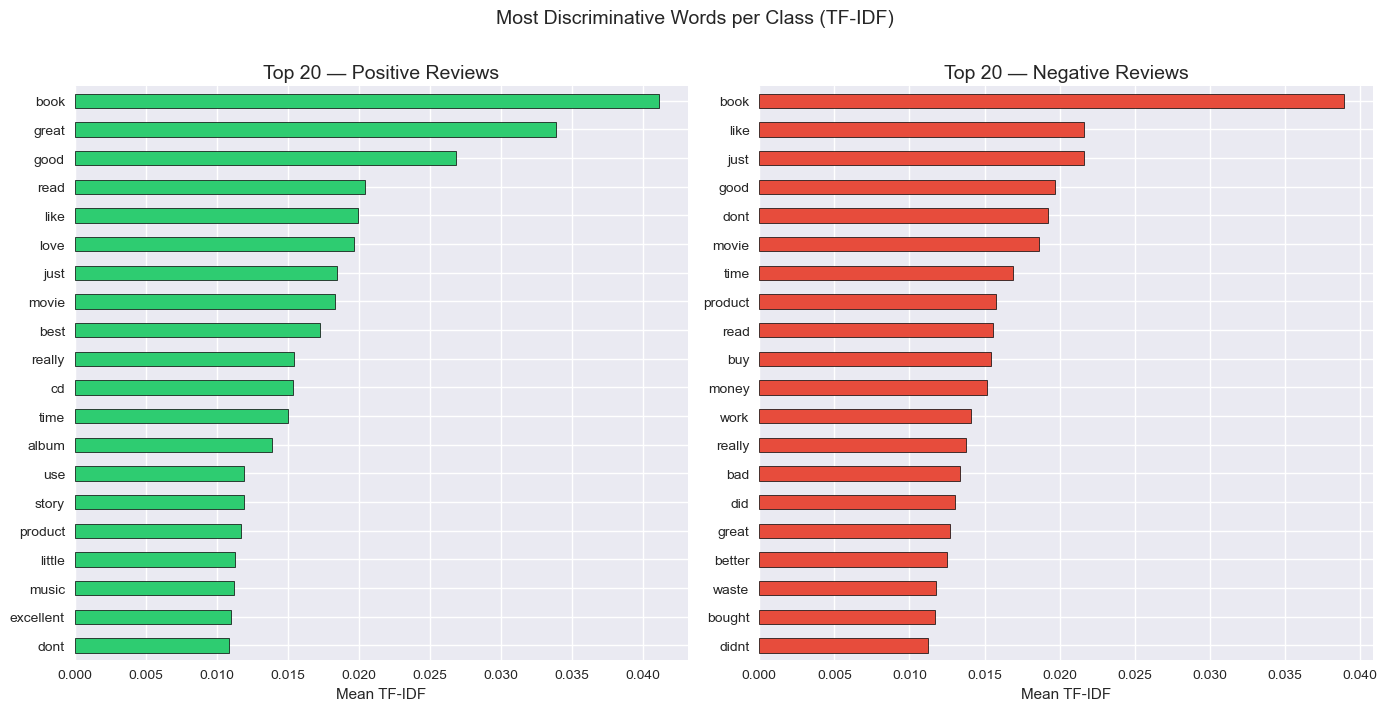

In [12]:
# ── Plot 4: Top 20 Discriminative Words per Class ────────────────────
vec_p = TfidfVectorizer(max_features=5000, stop_words="english")
vec_n = TfidfVectorizer(max_features=5000, stop_words="english")

X_p = vec_p.fit_transform(df_train[df_train["label"] == 1]["clean_text"])
X_n = vec_n.fit_transform(df_train[df_train["label"] == 0]["clean_text"])

top_pos = pd.Series(
    np.array(X_p.mean(axis=0)).flatten(),
    index=vec_p.get_feature_names_out()
).nlargest(20).sort_values()

top_neg = pd.Series(
    np.array(X_n.mean(axis=0)).flatten(),
    index=vec_n.get_feature_names_out()
).nlargest(20).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
top_pos.plot.barh(ax=axes[0], color=POS_COLOR, edgecolor="k", lw=0.5)
axes[0].set_title("Top 20 — Positive Reviews")
axes[0].set_xlabel("Mean TF-IDF")
top_neg.plot.barh(ax=axes[1], color=NEG_COLOR, edgecolor="k", lw=0.5)
axes[1].set_title("Top 20 — Negative Reviews")
axes[1].set_xlabel("Mean TF-IDF")
plt.suptitle("Most Discriminative Words per Class (TF-IDF)", fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "discriminative_words.png", dpi=150, bbox_inches="tight")
plt.show()

💡 **Feature engineering insight:** The discriminative word lists already
reveal what each class "talks about". Positive reviews use *comparative*
language ("best", "great", "excellent") while negative reviews use *concrete
failure terms* ("waste", "money", "return", "bad"). This asymmetry means a
simple bag-of-words model should already achieve high accuracy — the vocabulary
itself is strongly predictive.

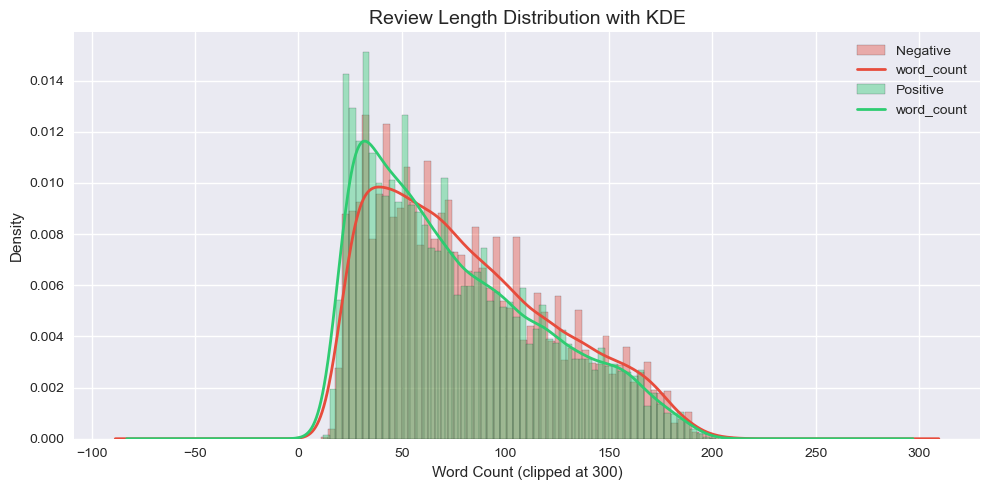

In [13]:
# ── Plot 5: Word Count Distribution with KDE ─────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))
for label in [0, 1]:
    data = df_train[df_train["label"] == label]["word_count"].clip(upper=300)
    ax.hist(data, bins=60, alpha=0.4, color=CLASS_PALETTE[label],
            label=LABEL_MAP[label], density=True, edgecolor="k", lw=0.3)
    data.plot.kde(ax=ax, color=CLASS_PALETTE[label], lw=2)

ax.set_title("Review Length Distribution with KDE")
ax.set_xlabel("Word Count (clipped at 300)")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
fig.savefig(FIGURES_DIR / "length_kde.png", dpi=150)
plt.show()

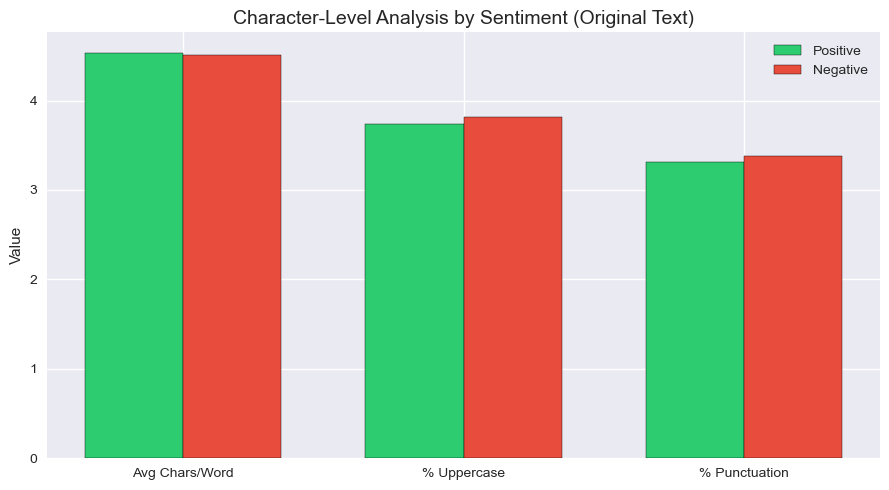

  Avg Chars/Word: Positive=4.54  Negative=4.51
  % Uppercase: Positive=3.74  Negative=3.82
  % Punctuation: Positive=3.31  Negative=3.38


In [14]:
# ── Plot 6: Character-Level Analysis ──────────────────────────────────
def char_stats(texts):
    """Compute character-level statistics for a list of texts."""
    avg_cpw = np.mean([np.mean([len(w) for w in t.split()])
                       if t.split() else 0 for t in texts])
    all_chars = "".join(texts)
    n = max(len(all_chars), 1)
    pct_upper = sum(c.isupper() for c in all_chars) / n * 100
    pct_punct = sum(c in string.punctuation for c in all_chars) / n * 100
    return avg_cpw, pct_upper, pct_punct

# Use ORIGINAL text (before cleaning) for character analysis
pos_stats = char_stats(df_train[df_train["label"] == 1]["text"].tolist())
neg_stats = char_stats(df_train[df_train["label"] == 0]["text"].tolist())

metrics = ["Avg Chars/Word", "% Uppercase", "% Punctuation"]
fig, ax = plt.subplots(figsize=(9, 5))
x = np.arange(len(metrics))
w = 0.35
ax.bar(x - w/2, pos_stats, w, color=POS_COLOR, label="Positive", edgecolor="k")
ax.bar(x + w/2, neg_stats, w, color=NEG_COLOR, label="Negative", edgecolor="k")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("Character-Level Analysis by Sentiment (Original Text)")
ax.set_ylabel("Value")
ax.legend()
plt.tight_layout()
fig.savefig(FIGURES_DIR / "char_analysis.png", dpi=150)
plt.show()

for m, p, n in zip(metrics, pos_stats, neg_stats):
    print(f"  {m}: Positive={p:.2f}  Negative={n:.2f}")

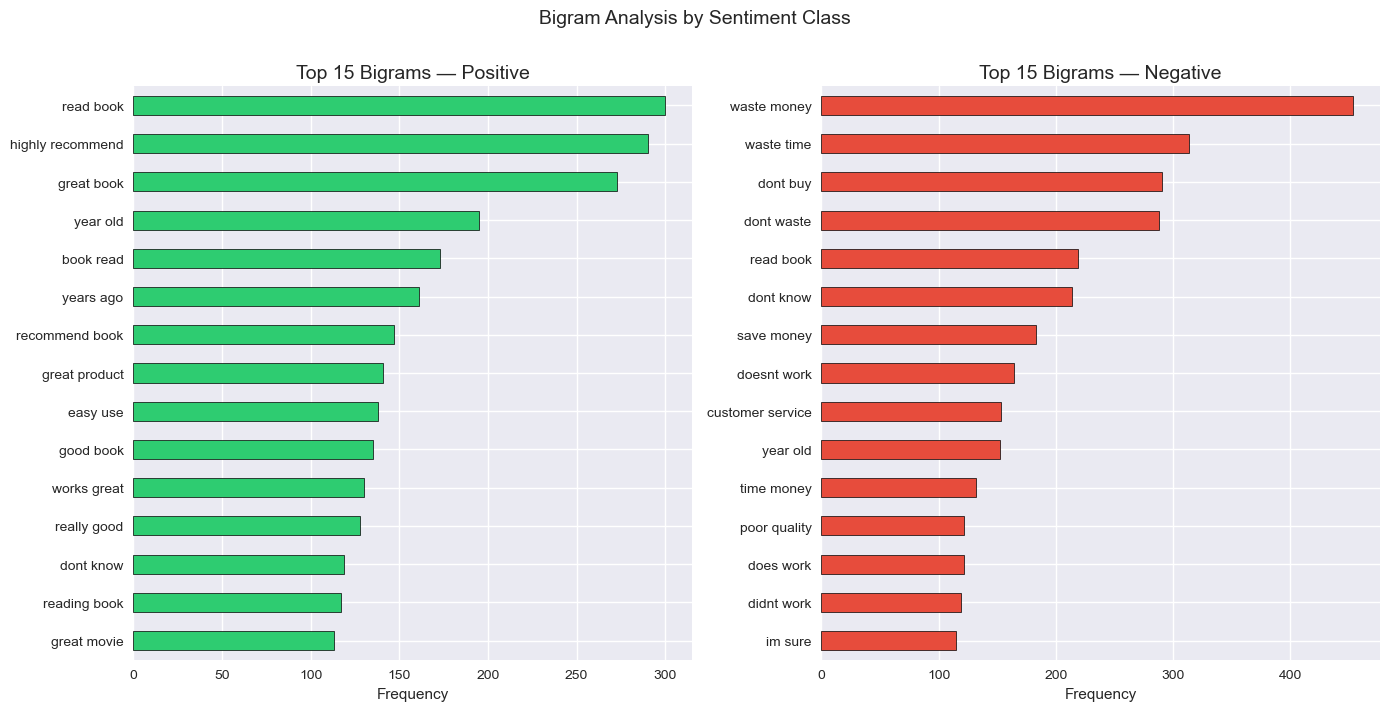

In [15]:
# ── Plot 7: Top 15 Bigrams per Class ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for ax, label, color, name in [
    (axes[0], 1, POS_COLOR, "Positive"),
    (axes[1], 0, NEG_COLOR, "Negative"),
]:
    bg_vec = CountVectorizer(ngram_range=(2, 2), stop_words="english",
                             max_features=10000)
    X_bg = bg_vec.fit_transform(df_train[df_train["label"] == label]["clean_text"])
    bigrams = pd.Series(
        np.array(X_bg.sum(axis=0)).flatten(),
        index=bg_vec.get_feature_names_out()
    ).nlargest(15).sort_values()
    bigrams.plot.barh(ax=ax, color=color, edgecolor="k", lw=0.5)
    ax.set_title(f"Top 15 Bigrams — {name}")
    ax.set_xlabel("Frequency")

plt.suptitle("Bigram Analysis by Sentiment Class", fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "bigrams.png", dpi=150, bbox_inches="tight")
plt.show()

💡 **Bigram insight:** Negative reviews frequently contain bigrams like
*"waste money"*, *"dont buy"*, *"waste time"* — these are **action-oriented
phrases** that signal product failure and buyer's remorse. Positive bigrams
like *"highly recommend"*, *"great product"*, *"well made"* are **endorsement
phrases**. Crucially, many of these bigrams lose meaning as individual words
("waste" appears in both classes; "waste money" is specifically negative).
This is why `ngram_range=(1,2)` in our TF-IDF vectoriser captures these
discriminative patterns.

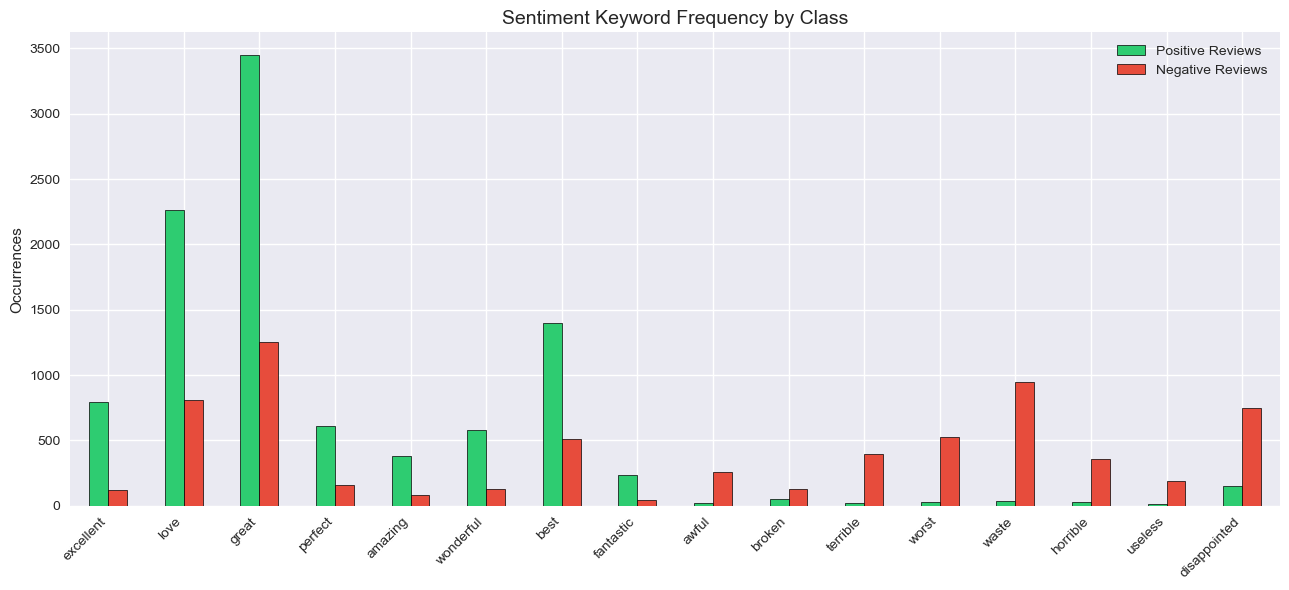

In [16]:
# ── Plot 8: Sentiment Keyword Frequency ──────────────────────────────
pos_keywords = ["excellent", "love", "great", "perfect",
                "amazing", "wonderful", "best", "fantastic"]
neg_keywords = ["awful", "broken", "terrible", "worst",
                "waste", "horrible", "useless", "disappointed"]

def count_keywords(texts, keywords):
    """Count keyword occurrences across a list of texts."""
    counts = {kw: 0 for kw in keywords}
    for text in texts:
        lower = text.lower()
        for kw in keywords:
            if kw in lower:
                counts[kw] += 1
    return counts

all_kw = pos_keywords + neg_keywords
pos_counts = count_keywords(df_train[df_train["label"] == 1]["text"], all_kw)
neg_counts = count_keywords(df_train[df_train["label"] == 0]["text"], all_kw)

kw_df = pd.DataFrame({
    "Positive Reviews": [pos_counts[k] for k in all_kw],
    "Negative Reviews": [neg_counts[k] for k in all_kw],
}, index=all_kw)

fig, ax = plt.subplots(figsize=(13, 6))
kw_df.plot.bar(ax=ax, color=[POS_COLOR, NEG_COLOR], edgecolor="k", lw=0.5)
ax.set_title("Sentiment Keyword Frequency by Class")
ax.set_ylabel("Occurrences")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "sentiment_keywords.png", dpi=150)
plt.show()

---
## 3. Stage 1 — Classical NLP Baseline (TF-IDF)

**Technical:** Convert cleaned text into numerical features using TF-IDF
(Term Frequency × Inverse Document Frequency), then train four classical
classifiers with 5-fold stratified cross-validation.

**NLP context:** TF-IDF has been the workhorse of text classification since
the 1970s. Despite its simplicity (it treats text as a "bag of words" — losing
all word order), it remains surprisingly competitive on binary sentiment tasks.
The key insight: **for sentiment, *which* words appear matters more than *what
order* they appear in.** "Excellent product" and "product excellent" carry the
same sentiment.

### TF-IDF Formula

$$\text{TF-IDF}(t, d) = \underbrace{\log(1 + \text{tf}(t,d))}_{\text{sublinear TF}} \times \underbrace{\log\!\left(\frac{N}{\text{df}(t)}\right)}_{\text{IDF: penalises common words}}$$

- **`sublinear_tf=True`** uses $\log(1 + \text{tf})$ instead of raw counts —
  prevents very long reviews from dominating
- **IDF** down-weights words that appear in many documents ("the", "is", "and")
  even if they survive the stopword filter

In [17]:
# ── Feature Extraction: TF-IDF and Count Vectorizers ─────────────────
vec_tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),
    min_df=3, max_df=0.95,
    stop_words="english",
    sublinear_tf=True,
)
vec_count = CountVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1, 2),
    min_df=3,
    stop_words="english",
)

X_tfidf_train = vec_tfidf.fit_transform(df_train["clean_text"])
X_tfidf_test  = vec_tfidf.transform(df_test["clean_text"])
X_count_train = vec_count.fit_transform(df_train["clean_text"])
X_count_test  = vec_count.transform(df_test["clean_text"])

# Save vectorizer
joblib.dump(vec_tfidf, MODELS_DIR / "tfidf_vectorizer.pkl")

n_feats = X_tfidf_train.shape[1]
sparsity = 1.0 - X_tfidf_train.nnz / (X_tfidf_train.shape[0] * X_tfidf_train.shape[1])
print(f"✅ TF-IDF vocabulary: {n_feats:,} features")
print(f"   Matrix sparsity:  {sparsity:.1%}")
print(f"   Count vocabulary:  {X_count_train.shape[1]:,} features")

✅ TF-IDF vocabulary: 39,465 features
   Matrix sparsity:  99.9%
   Count vocabulary:  39,465 features


In [18]:
# ── Train 4 Classical Models with 5-Fold CV ──────────────────────────
models_stage1 = {
    "Logistic Regression": LogisticRegression(
        C=1.0, max_iter=1000, random_state=SEED, n_jobs=-1),
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "SVM (Linear)": LinearSVC(
        C=1.0, random_state=SEED, max_iter=2000),
    "SGD Classifier": SGDClassifier(
        loss="modified_huber", random_state=SEED, n_jobs=-1),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
results_s1 = []
preds_s1   = {}
probas_s1  = {}

for name, model in models_stage1.items():
    is_nb = "Naive Bayes" in name
    X_tr = X_count_train if is_nb else X_tfidf_train
    X_te = X_count_test  if is_nb else X_tfidf_test

    # Cross-validation
    cv_res = cross_validate(
        model, X_tr, y_train, cv=cv,
        scoring=["accuracy", "f1"], n_jobs=-1,
    )
    cv_acc = cv_res["test_accuracy"]
    cv_f1  = cv_res["test_f1"]

    # Full train + test evaluation
    t0 = time.time()
    model.fit(X_tr, y_train)
    train_time = time.time() - t0

    t0 = time.time()
    y_pred = model.predict(X_te)
    infer_time = time.time() - t0

    preds_s1[name] = y_pred

    # AUC (use predict_proba or decision_function)
    try:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_te)[:, 1]
        elif hasattr(model, "decision_function"):
            proba = model.decision_function(X_te)
        else:
            proba = None
        auc_score = roc_auc_score(y_test, proba) if proba is not None else np.nan
        probas_s1[name] = proba
    except Exception:
        auc_score = np.nan
        probas_s1[name] = None

    results_s1.append({
        "Model": name, "Stage": 1,
        "CV Acc": f"{cv_acc.mean():.3f} ± {cv_acc.std():.3f}",
        "CV F1":  f"{cv_f1.mean():.3f} ± {cv_f1.std():.3f}",
        "Test Acc": accuracy_score(y_test, y_pred),
        "Test F1":  f1_score(y_test, y_pred),
        "Test AUC": auc_score,
        "Train (s)": round(train_time, 2),
        "Infer (ms/sample)": round(infer_time / len(y_test) * 1000, 3),
    })
    print(f"  ✓ {name:25s}  CV Acc={cv_acc.mean():.3f}  Test F1={f1_score(y_test, y_pred):.3f}")

df_results_s1 = pd.DataFrame(results_s1).sort_values("Test F1", ascending=False)
print("\n✅ All Stage 1 models trained")

  ✓ Logistic Regression        CV Acc=0.866  Test F1=0.870
  ✓ Naive Bayes                CV Acc=0.834  Test F1=0.846
  ✓ SVM (Linear)               CV Acc=0.864  Test F1=0.874
  ✓ SGD Classifier             CV Acc=0.866  Test F1=0.874

✅ All Stage 1 models trained


In [19]:
# ── Stage 1 Results Table ─────────────────────────────────────────────
df_results_s1

,Model,Stage,CV Acc,CV F1,Test Acc,Test F1,Test AUC,Train (s),Infer (ms/sample)
2,SVM (Linear),1,0.864 ± 0.003,0.864 ± 0.003,0.87275,0.873729,0.942488,0.08,0.000
3,SGD Classifier,1,0.866 ± 0.003,0.866 ± 0.003,0.87350,0.873500,0.945037,0.04,0.000
0,Logistic Regression,1,0.866 ± 0.005,0.867 ± 0.005,0.86925,0.869868,0.942865,0.89,0.001
1,Naive Bayes,1,0.834 ± 0.006,0.834 ± 0.005,0.84500,0.846459,0.914584,0.01,0.001


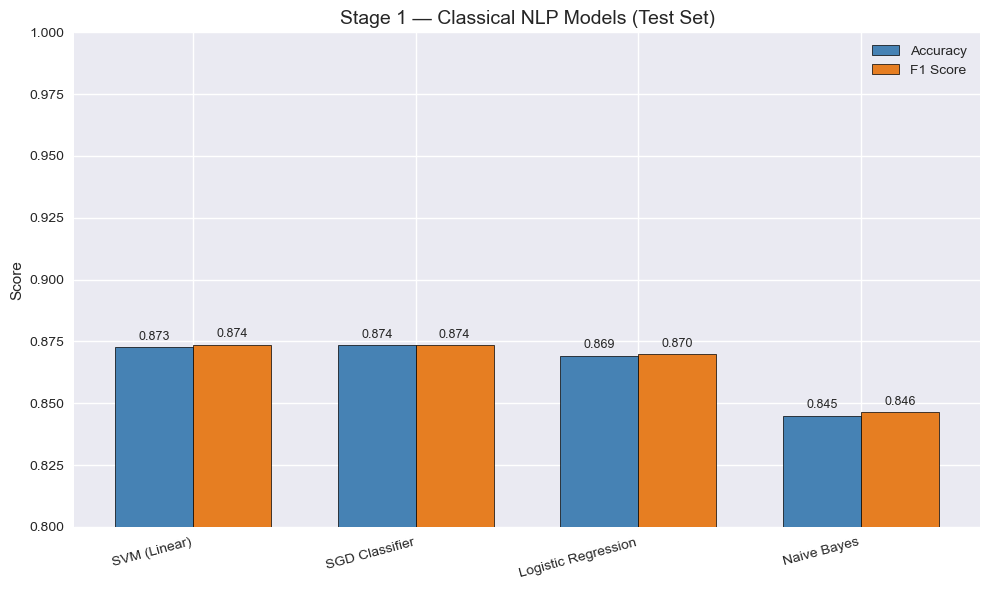

In [20]:
# ── Stage 1: Accuracy & F1 Grouped Barplot ───────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df_results_s1))
w = 0.35

ax.bar(x - w/2, df_results_s1["Test Acc"], w, label="Accuracy",
       color="steelblue", edgecolor="k", lw=0.5)
ax.bar(x + w/2, df_results_s1["Test F1"], w, label="F1 Score",
       color="#e67e22", edgecolor="k", lw=0.5)

ax.set_xticks(x)
ax.set_xticklabels(df_results_s1["Model"], rotation=15, ha="right")
ax.set_ylim(0.80, 1.0)
ax.set_title("Stage 1 — Classical NLP Models (Test Set)")
ax.set_ylabel("Score")
ax.legend()

for i, (acc, f1) in enumerate(zip(df_results_s1["Test Acc"], df_results_s1["Test F1"])):
    ax.text(i - w/2, acc + 0.003, f"{acc:.3f}", ha="center", fontsize=9)
    ax.text(i + w/2, f1  + 0.003, f"{f1:.3f}",  ha="center", fontsize=9)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "stage1_barplot.png", dpi=150)
plt.show()

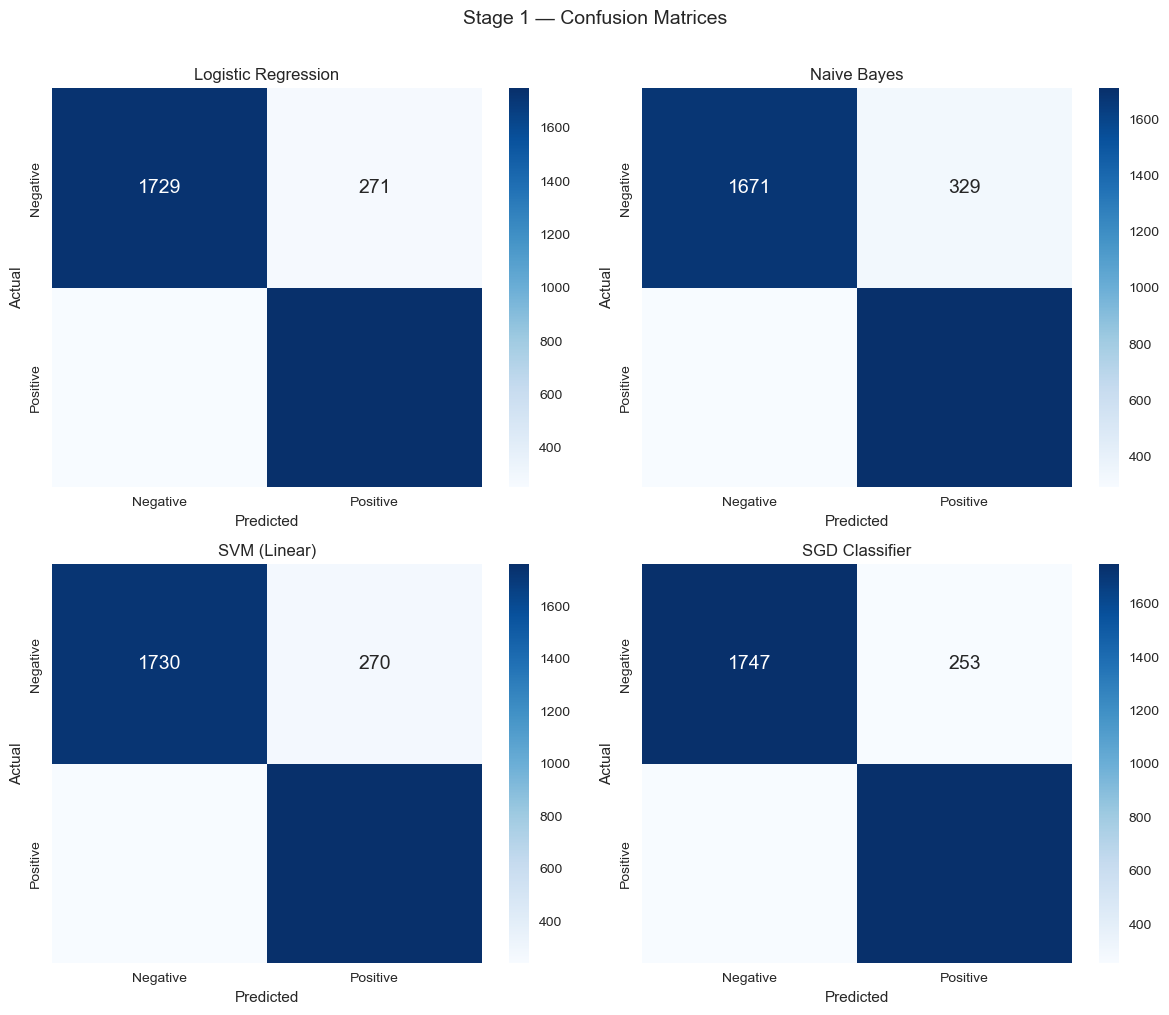

In [21]:
# ── Stage 1: Confusion Matrices (2×2 grid) ───────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, y_pred) in zip(axes.ravel(), preds_s1.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"],
                annot_kws={"fontsize": 14})
    ax.set_title(name, fontsize=12)
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")

plt.suptitle("Stage 1 — Confusion Matrices", fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "stage1_confusion.png", dpi=150, bbox_inches="tight")
plt.show()

In [22]:
# ── Classification Reports (all models) ──────────────────────────────
for name, y_pred in preds_s1.items():
    print(f"\n{'='*55}")
    print(f"  {name}")
    print(f"{'='*55}")
    print(classification_report(y_test, y_pred,
                                target_names=["Negative", "Positive"]))


  Logistic Regression
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      2000
    Positive       0.87      0.87      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000


  Naive Bayes
              precision    recall  f1-score   support

    Negative       0.85      0.84      0.84      2000
    Positive       0.84      0.85      0.85      2000

    accuracy                           0.84      4000
   macro avg       0.85      0.84      0.84      4000
weighted avg       0.85      0.84      0.84      4000


  SVM (Linear)
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      2000
    Positive       0.87      0.88      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0

### 📌 Key weakness of bag-of-words

TF-IDF treats text as an **unordered bag of tokens** — it cannot distinguish:
- *"not good"* (negative) from *"good"* (positive)
- *"I expected terrible but got great"* (positive) from *"terrible"* (negative)

These **negation** and **contrastive** constructions require understanding word
order and context — exactly what word embeddings (Stage 2) and transformers
(Stage 3) will address.

### 🔍 Deep-Dive: Logistic Regression

Logistic Regression assigns a **weight (coefficient)** to every feature in the
TF-IDF vocabulary. The sign and magnitude of each weight directly tell us which
words drive the model's decisions — making LR one of the most interpretable NLP
models available.

✅ Saved: outputs/models/logreg_model.pkl


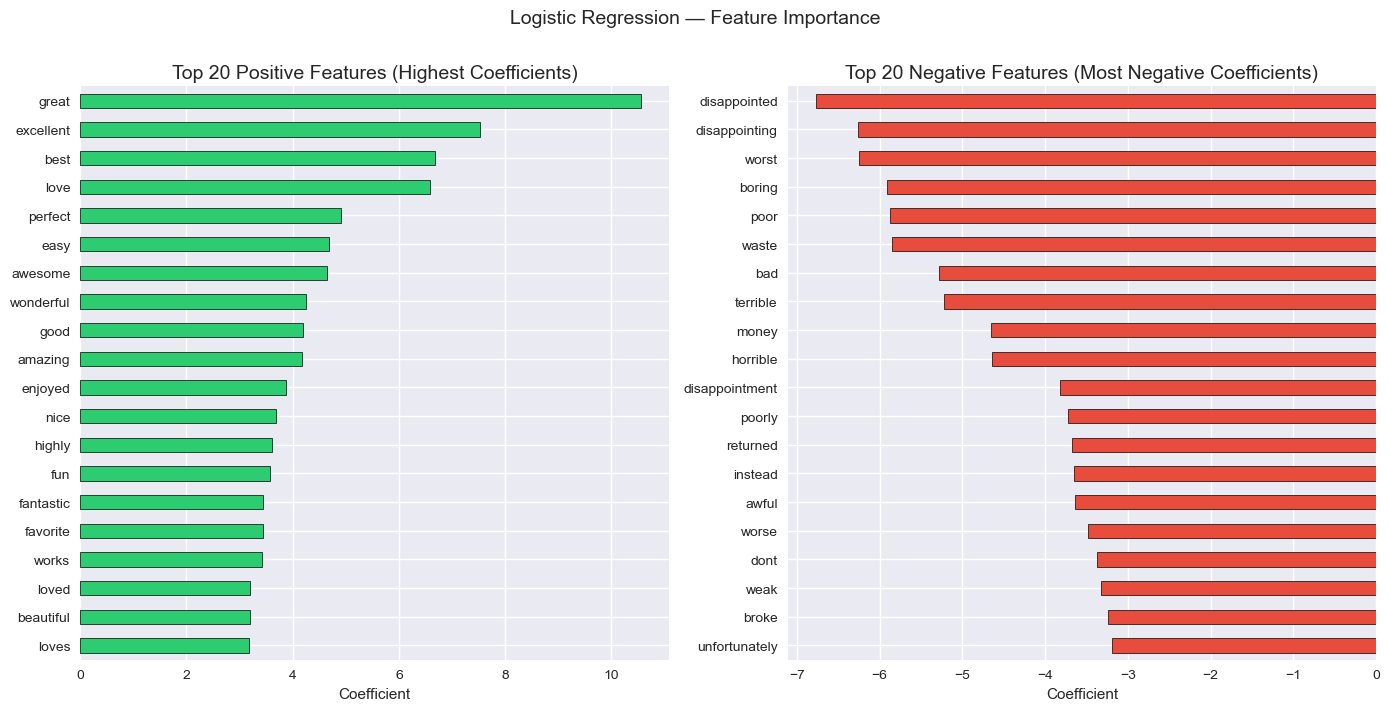

In [23]:
# ── Save best model ───────────────────────────────────────────────────
logreg = models_stage1["Logistic Regression"]
joblib.dump(logreg, MODELS_DIR / "logreg_model.pkl")
print(f"✅ Saved: {MODELS_DIR / 'logreg_model.pkl'}")

# ── Top 20 Positive & Negative Features ─────────────────────────────
feature_names = vec_tfidf.get_feature_names_out()
coeffs = logreg.coef_[0]

top_pos_idx = np.argsort(coeffs)[-20:]
top_neg_idx = np.argsort(coeffs)[:20]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Positive features
pos_feats = pd.Series(coeffs[top_pos_idx], index=feature_names[top_pos_idx]).sort_values()
pos_feats.plot.barh(ax=axes[0], color=POS_COLOR, edgecolor="k", lw=0.5)
axes[0].set_title("Top 20 Positive Features (Highest Coefficients)")
axes[0].set_xlabel("Coefficient")

# Negative features
neg_feats = pd.Series(coeffs[top_neg_idx], index=feature_names[top_neg_idx]).sort_values(ascending=False)
neg_feats.plot.barh(ax=axes[1], color=NEG_COLOR, edgecolor="k", lw=0.5)
axes[1].set_title("Top 20 Negative Features (Most Negative Coefficients)")
axes[1].set_xlabel("Coefficient")

plt.suptitle("Logistic Regression — Feature Importance", fontsize=14, y=1.01)
plt.tight_layout()
fig.savefig(FIGURES_DIR / "logreg_features.png", dpi=150, bbox_inches="tight")
plt.show()

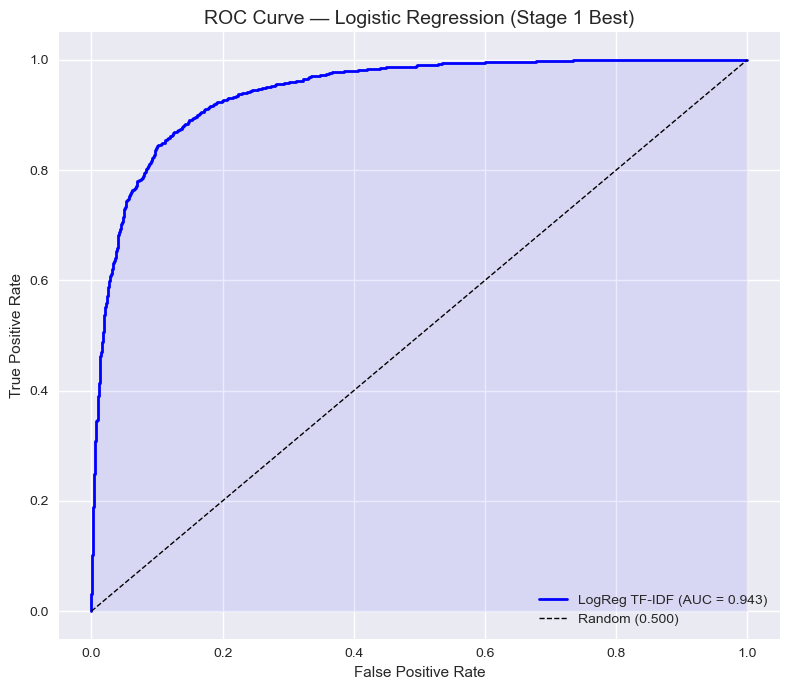

ROC-AUC: 0.9429


In [24]:
# ── ROC Curve — Logistic Regression ──────────────────────────────────
y_proba_lr = logreg.predict_proba(X_tfidf_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(fpr_lr, tpr_lr, "b-", lw=2, label=f"LogReg TF-IDF (AUC = {auc_lr:.3f})")
ax.plot([0, 1], [0, 1], "k--", lw=1, label="Random (0.500)")
ax.fill_between(fpr_lr, tpr_lr, alpha=0.08, color="blue")
ax.set_title("ROC Curve — Logistic Regression (Stage 1 Best)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.tight_layout()
fig.savefig(FIGURES_DIR / "stage1_roc.png", dpi=150)
plt.show()
print(f"ROC-AUC: {auc_lr:.4f}")

In [25]:
# ── Error Analysis: False Positives & False Negatives ────────────────
y_pred_lr = logreg.predict(X_tfidf_test)
y_proba_lr = logreg.predict_proba(X_tfidf_test)[:, 1]

fp_mask = (y_pred_lr == 1) & (y_test == 0)
fn_mask = (y_pred_lr == 0) & (y_test == 1)

print("="*60)
print("  FALSE POSITIVES (predicted positive, actually negative)")
print("="*60)
fp_idx = np.where(fp_mask)[0]
for i in fp_idx[:3]:
    text = df_test.iloc[i]["text"][:200]
    print(f"\n  Confidence: {y_proba_lr[i]:.2f}")
    print(f"  ▸ {text} …")

print(f"\n{'='*60}")
print("  FALSE NEGATIVES (predicted negative, actually positive)")
print(f"{'='*60}")
fn_idx = np.where(fn_mask)[0]
for i in fn_idx[:3]:
    text = df_test.iloc[i]["text"][:200]
    print(f"\n  Confidence: {y_proba_lr[i]:.2f}")
    print(f"  ▸ {text} …")

n_fp = fp_mask.sum()
n_fn = fn_mask.sum()
print(f"\nTotal errors: {n_fp + n_fn} / {len(y_test)} "
      f"({(n_fp + n_fn)/len(y_test):.1%})")
print(f"  False Positives: {n_fp}  |  False Negatives: {n_fn}")

  FALSE POSITIVES (predicted positive, actually negative)

  Confidence: 0.72
  ▸ Great bracket, junk strap. These brackets are nicely finished and easy to adjust and use. The included straps have a really nice padded surround on the buckle, but the buckle itself is totally unsafe. …

  Confidence: 0.53
  ▸ Great Camera, but storage isn't. Great camera. Great pictures. But -- the storage is terrible! A floppy disk can hold only so many images... AND it'll hold only ONE megapixel image. There are better s …

  Confidence: 0.69
  ▸ Better films out there. so soWarren Oates has done better in other films. He never seems to have beengiven really good roles. …

  FALSE NEGATIVES (predicted negative, actually positive)

  Confidence: 0.25
  ▸ Amazing First Novel. I bought T.C.H. along with four or five other novels and made the mistake of reading this one first. The rest didn't even come close - a new benchmark for writing. Clevenger hit i …

  Confidence: 0.48
  ▸ Drinking beer in minutes. 

### 📌 Why does the model fail?

Common failure modes for TF-IDF + Logistic Regression:

1. **Sarcasm / irony:** *"Oh great, another product that doesn't work"* — the
   word "great" pushes positive, but the overall sentiment is negative.
2. **Negation:** *"Not bad at all"* — the model sees "bad" (negative coefficient)
   but misses the negation "not".
3. **Mixed sentiment:** *"Great packaging but the product itself is garbage"* —
   opposing signals cancel out, leaving the model uncertain.
4. **Domain-specific vocabulary:** Product-specific terms the model hasn't seen
   enough of in training.

These are **structural limitations of bag-of-words** — they cannot be fixed by
tuning hyperparameters. Addressing them requires models that understand **word
order** (embeddings, attention).

---

✅ **Sections 0–3 complete.** Reply **CONTINUE** for Sections 4–6
(GloVe embeddings, DistilBERT fine-tuning, error analysis).